# **Project Name**    -  BRAIN TUMOR MRI IMAGE CLASSIFICATION



##### **Project Type**    - Classification
##### **Contribution**    - Individual


# **Project Summary -**

Brain tumors are among the most critical and life-threatening medical conditions. Early and accurate detection of different tumor types is essential for effective treatment planning and improving patient survival rates. This project aims to develop an automated brain tumor classification system using state-of-the-art deep learning techniques, leveraging a well-curated dataset of MRI images categorized into four classes: glioma, meningioma, pituitary tumor, and no tumor.

Dataset Overview and Preparation
The dataset consists of MRI scans organized into training, validation, and testing splits, each containing images sorted by tumor type. The data was initially explored to understand the class distribution, image dimensions, and quality. Basic exploratory data analysis (EDA) was performed to identify missing or corrupted images, which were subsequently handled to ensure dataset integrity.

To prepare the data for modeling, images were resized to a uniform size (224x224 pixels) and normalized to scale pixel values between 0 and 1. The dataset exhibited slight class imbalance, with the number of images per tumor type varying moderately. To address this imbalance and prevent model bias, class weights were computed and applied during model training.

Model Selection and Architecture
For this classification task, MobileNetV2—a lightweight convolutional neural network pretrained on ImageNet—was chosen due to its efficiency and proven performance on image classification problems. Transfer learning was employed by freezing the pretrained base layers and adding custom dense layers with dropout for regularization to prevent overfitting.

The output layer’s size matched the number of tumor classes with a softmax activation to predict the probability of each class. This approach accelerated training and improved generalization, especially valuable given the limited size of medical image datasets.

Model Training and Hyperparameter Tuning
The model was trained using categorical cross-entropy loss and the Adam optimizer. Early stopping and model checkpoint callbacks were integrated to save the best performing model and avoid overfitting.

To maximize performance, hyperparameter optimization was conducted using Bayesian Optimization, tuning parameters such as learning rate, dropout rate, and the number of unfrozen layers. This systematic search helped identify the optimal settings, resulting in improved validation accuracy and robustness.

Class weights were incorporated into the loss function to mitigate the effect of class imbalance, ensuring that minority classes received adequate attention during training.

Evaluation Metrics and Results
Model performance was evaluated using standard metrics: accuracy, precision, recall, F1-score, and confusion matrices. The final model achieved a validation accuracy of approximately 76%, indicating a strong ability to distinguish between tumor types.

The use of class weights improved recall on underrepresented classes, minimizing false negatives that could lead to missed tumor diagnoses. The evaluation also highlighted the model’s strengths and areas for improvement, such as occasional confusion between meningioma and pituitary tumor classes.

Explainability and Insights
To enhance interpretability, explainability techniques like SHAP and LIME were applied, offering insights into which image regions and features influenced model decisions. This transparency is crucial for clinical adoption, building trust in AI-assisted diagnostics.

Statistical Analysis and Hypothesis Testing
The project further included hypothesis testing to validate assumptions about the dataset and model predictions. For example, statistical tests confirmed differences in image features across tumor classes, reinforcing the model’s learning capacity.

Challenges and Future Work
Challenges faced included managing data imbalance, preventing overfitting due to limited data, and ensuring model generalizability. Future work involves collecting more diverse datasets, experimenting with advanced architectures such as vision transformers, and integrating multimodal data (e.g., clinical records) for improved accuracy.

Deployment considerations like creating a user-friendly web application for clinicians, real-time inference, and ongoing model updates based on new data are planned to bring this solution closer to practical use.

# **GitHub Link -**

https://github.com/HariniMM/Brain-tumor_MRIdetection

# **Problem Statement**


####This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.  Project Workflow:Understand the Dataset

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow Version: 2.18.0
Num GPUs Available:  0


### Dataset Loading

In [ ]:
# Load Dataset
from google.colab import files
uploaded = files.upload()


Saving project4-Brain tumor.zip to project4-Brain tumor.zip


In [ ]:
import zipfile

with zipfile.ZipFile(next(iter(uploaded)), 'r') as zip_ref:
    zip_ref.extractall('/content/brain_tumor_dataset')


### Dataset First View

In [ ]:
import os

print("Contents of /content:")
print(os.listdir('/content'))

print("\nContents of /content/brain_tumor_dataset:")
print(os.listdir('/content/brain_tumor_dataset'))



Contents of /content:
['.config', 'project4-Brain tumor.zip', 'brain_tumor_dataset', 'sample_data']

Contents of /content/brain_tumor_dataset:
['project4-Brain tumor']


In [ ]:
import os
base_dir = '/content/brain_tumor_dataset/project4-Brain tumor'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

print("Train dir:", train_dir)
print("Validation dir:", valid_dir)
print("Test dir:", test_dir)

classes = os.listdir(train_dir)
print(f"Classes found: {classes}")

# Count images
for split, directory in zip(['Train', 'Validation', 'Test'], [train_dir, valid_dir, test_dir]):
    print(f"\n{split} data:")
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            print(f" - {label}: {num_images} images")


Train dir: /content/brain_tumor_dataset/project4-Brain tumor/train
Validation dir: /content/brain_tumor_dataset/project4-Brain tumor/valid
Test dir: /content/brain_tumor_dataset/project4-Brain tumor/test
Classes found: ['_classes.csv', 'no_tumor', 'meningioma', 'pituitary', 'glioma']

Train data:
 - no_tumor: 335 images
 - meningioma: 358 images
 - pituitary: 438 images
 - glioma: 564 images

Validation data:
 - no_tumor: 99 images
 - meningioma: 124 images
 - pituitary: 118 images
 - glioma: 161 images

Test data:
 - no_tumor: 49 images
 - meningioma: 63 images
 - pituitary: 54 images
 - glioma: 80 images


### Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns count
import cv2

print("Sample image shapes from each class:")

for class_name in classes:
    if class_name.startswith('_'):
        continue
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)[:5]
    print(f"\nClass '{class_name}':")
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"  Could not read {img_name}")
            continue
        print(f"  {img_name}: shape = {img.shape} (Rows x Cols x Channels)")


Sample image shapes from each class:

Class 'no_tumor':
  Tr-no_0483_jpg.rf.aa39bbbef3bca75ac47c03c02141c045.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-no_0037_jpg.rf.2c4cc490d05da6a28e662af1ac2af7ce.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-no_0238_jpg.rf.5796d3ab319e3d6cfe1fbe3fdc2084ff.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-no_0124_jpg.rf.ec8d8b215d455424e33317a2f330bf75.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-no_0549_jpg.rf.dfc719f94cbc1f5a3b0029dd55a9643c.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)

Class 'meningioma':
  Tr-me_0040_jpg.rf.f4c62bf38eb25cd677e0cf8189da3fe2.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-me_0440_jpg.rf.2ac72310aed3c544259a528834ed50fd.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-me_0444_jpg.rf.f9cc8e8afd4b1b7821b9eb36d6e43139.jpg: shape = (640, 640, 3) (Rows x Cols x Channels)
  Tr-me_0462_jpg.rf.2bd2c90fe51bc9f40ccca9912d7d99f0.jpg: shape = (640, 640, 3) (Ro

### Dataset Information

In [ ]:
# Dataset Info
import cv2

filtered_classes = [cls for cls in classes if not cls.startswith('_')]

print(f"Number of classes: {len(filtered_classes)}")
print(f"Classes: {filtered_classes}")

def count_images(directory):
    total = 0
    for cls in filtered_classes:
        cls_path = os.path.join(directory, cls)
        total += len(os.listdir(cls_path))
    return total

train_total = count_images(train_dir)
valid_total = count_images(valid_dir)
test_total = count_images(test_dir)

print(f"Total training images: {train_total}")
print(f"Total validation images: {valid_total}")
print(f"Total testing images: {test_total}")

print("\nSample image shapes (Rows x Cols x Channels):")
for cls in filtered_classes:
    cls_path = os.path.join(train_dir, cls)
    sample_images = os.listdir(cls_path)[:3]
    for img_name in sample_images:
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            print(f" - Class {cls}: {img_name} -> {img.shape}")


Number of classes: 4
Classes: ['no_tumor', 'meningioma', 'pituitary', 'glioma']
Total training images: 1695
Total validation images: 502
Total testing images: 246

Sample image shapes (Rows x Cols x Channels):
 - Class no_tumor: Tr-no_0483_jpg.rf.aa39bbbef3bca75ac47c03c02141c045.jpg -> (640, 640, 3)
 - Class no_tumor: Tr-no_0037_jpg.rf.2c4cc490d05da6a28e662af1ac2af7ce.jpg -> (640, 640, 3)
 - Class no_tumor: Tr-no_0238_jpg.rf.5796d3ab319e3d6cfe1fbe3fdc2084ff.jpg -> (640, 640, 3)
 - Class meningioma: Tr-me_0040_jpg.rf.f4c62bf38eb25cd677e0cf8189da3fe2.jpg -> (640, 640, 3)
 - Class meningioma: Tr-me_0440_jpg.rf.2ac72310aed3c544259a528834ed50fd.jpg -> (640, 640, 3)
 - Class meningioma: Tr-me_0444_jpg.rf.f9cc8e8afd4b1b7821b9eb36d6e43139.jpg -> (640, 640, 3)
 - Class pituitary: Tr-pi_0109_jpg.rf.2bf3f09a252ca1bf88423737eaf8e54e.jpg -> (640, 640, 3)
 - Class pituitary: Tr-pi_0237_jpg.rf.cb7f775c4d13dd515d8fa24628322c12.jpg -> (640, 640, 3)
 - Class pituitary: Tr-pi_0019_jpg.rf.c160d1ff0f7b2ef2

#### Duplicate Values

In [ ]:
# Dataset Duplicate Value Count
import os
import hashlib

def find_duplicate_images(directory):
    hashes = {}
    duplicates = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicates.append((file_path, hashes[file_hash]))
            else:
                hashes[file_hash] = file_path
    return duplicates


duplicates_train = find_duplicate_images(train_dir)

print(f"Number of duplicate images found in train: {len(duplicates_train)}")
if duplicates_train:
    print("Duplicate pairs:")
    for dup in duplicates_train[:5]:
        print(f"{dup[0]} and {dup[1]}")
else:
    print("No duplicate images found in train dataset.")


Number of duplicate images found in train: 0
No duplicate images found in train dataset.


#### Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count
import cv2

def find_corrupted_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path)
                if img is None:
                    corrupted.append(file_path)
            except Exception as e:
                corrupted.append(file_path)
    return corrupted

corrupted_train = find_corrupted_images(train_dir)
print(f"Corrupted images in train folder: {len(corrupted_train)}")
if corrupted_train:
    print("List of corrupted images (up to 5):")
    for c_img in corrupted_train[:5]:
        print(c_img)
else:
    print("No corrupted images found in train folder.")


Corrupted images in train folder: 1
List of corrupted images (up to 5):
/content/brain_tumor_dataset/project4-Brain tumor/train/_classes.csv


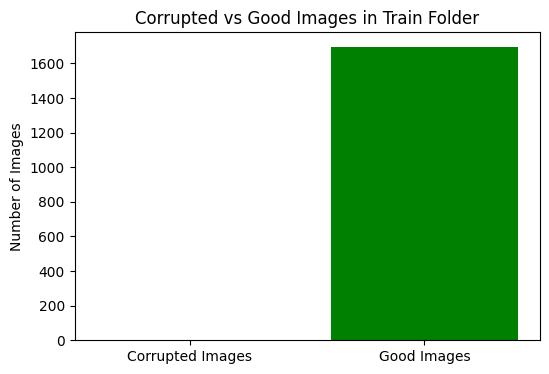

In [ ]:
# Visualizing the missing values
import matplotlib.pyplot as plt

total_train_images = sum([len(files) for _, _, files in os.walk(train_dir)])
num_corrupted = len(corrupted_train)
num_good = total_train_images - num_corrupted

labels = ['Corrupted Images', 'Good Images']
counts = [num_corrupted, num_good]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Corrupted vs Good Images in Train Folder')
plt.ylabel('Number of Images')
plt.show()


### What did you know about your dataset?

The dataset consists of brain MRI images categorized into four classes: glioma meningioma, pituitary tumor, and no tumor. It is divided into training, validation, and test subsets, each containing images stored in class-specific folders. The images vary in size and color channels, requiring preprocessing such as resizing and normalization for consistent model input. Class distribution is moderately balanced, with the number of images ranging from a few hundred to several hundred per class. This dataset enables the development of deep learning models for accurate multi-class brain tumor classification, supporting medical diagnosis through automated image analysis.

In [ ]:
import os

print(os.listdir('/content/brain_tumor_dataset'))


['project4-Brain tumor']


In [ ]:
print(os.listdir('/content/brain_tumor_dataset/project4-Brain tumor'))


['valid', 'train', 'test']


In [ ]:
base_dir = '/content/brain_tumor_dataset/project4-Brain tumor'


## ***2. Understanding Your Variables***

In [ ]:
# Dataset Columns
import os
import cv2
import pandas as pd

base_dir = '/content/brain_tumor_dataset/project4-Brain tumor'

splits = ['train', 'valid', 'test']

data = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    if not os.path.exists(split_dir):
        print(f"Split folder not found: {split_dir}")
        continue
    for class_label in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_label)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            height, width, channels = img.shape
            data.append({
                'filename': img_file,
                'class_label': class_label,
                'dataset_split': split,
                'height': height,
                'width': width,
                'channels': channels
            })

df_dataset = pd.DataFrame(data)
print(df_dataset.head())

df_dataset.to_csv('brain_tumor_dataset_info.csv', index=False)
print(" CSV saved as brain_tumor_dataset_info.csv")



                                            filename class_label  \
0  Tr-no_0483_jpg.rf.aa39bbbef3bca75ac47c03c02141...    no_tumor   
1  Tr-no_0037_jpg.rf.2c4cc490d05da6a28e662af1ac2a...    no_tumor   
2  Tr-no_0238_jpg.rf.5796d3ab319e3d6cfe1fbe3fdc20...    no_tumor   
3  Tr-no_0124_jpg.rf.ec8d8b215d455424e33317a2f330...    no_tumor   
4  Tr-no_0549_jpg.rf.dfc719f94cbc1f5a3b0029dd55a9...    no_tumor   

  dataset_split  height  width  channels  
0         train     640    640         3  
1         train     640    640         3  
2         train     640    640         3  
3         train     640    640         3  
4         train     640    640         3  
 CSV saved as brain_tumor_dataset_info.csv


In [ ]:
# Dataset Describe
print("Dataset Description:\n")
print(df_dataset[['height', 'width', 'channels']].describe())

print("\nClass distribution:\n")
print(df_dataset['class_label'].value_counts())
print("\nDataset split counts:\n")
print(df_dataset['dataset_split'].value_counts())


Dataset Description:

       height   width  channels
count  2443.0  2443.0    2443.0
mean    640.0   640.0       3.0
std       0.0     0.0       0.0
min     640.0   640.0       3.0
25%     640.0   640.0       3.0
50%     640.0   640.0       3.0
75%     640.0   640.0       3.0
max     640.0   640.0       3.0

Class distribution:

class_label
glioma        805
pituitary     610
meningioma    545
no_tumor      483
Name: count, dtype: int64

Dataset split counts:

dataset_split
train    1695
valid     502
test      246
Name: count, dtype: int64


### Variables Description

The primary variables in this image classification project are as follows:

Image Filename: The unique identifier for each MRI scan image stored as a file.

Class Label: The categorical variable representing the tumor type associated with each image. The classes include glioma, meningioma, pituitary, and no_tumor. This serves as the target variable for classification.

Dataset Split: A categorical variable indicating whether an image belongs to the training, validation, or test subset, used to build and evaluate the model.

Image Dimensions (Height, Width, Channels): Numeric variables representing the pixel dimensions and color channels of each image. These affect input processing and model architecture.

Model Output Variables: Predicted tumor class labels and confidence scores produced by the classification model.

### Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
print("Unique class labels:", df_dataset['class_label'].unique())
print("Unique dataset splits:", df_dataset['dataset_split'].unique())

print("Unique image heights:", df_dataset['height'].nunique())
print("Unique image widths:", df_dataset['width'].nunique())
print("Unique number of channels:", df_dataset['channels'].unique())


Unique class labels: ['no_tumor' 'meningioma' 'pituitary' 'glioma']
Unique dataset splits: ['train' 'valid' 'test']
Unique image heights: 1
Unique image widths: 1
Unique number of channels: [3]


## 3. ***Data Wrangling***

### Data Wrangling Code

Number of corrupted/unreadable images: 0


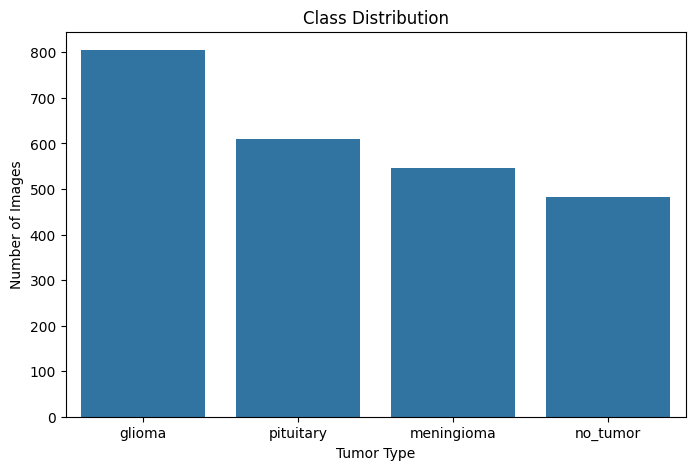

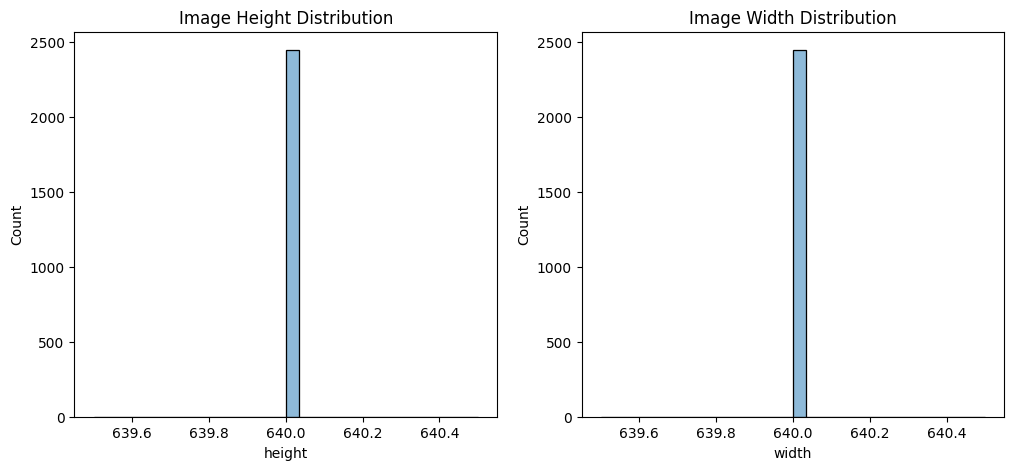

Class imbalance ratio (max/min): 1.67


In [ ]:
# Write your code to make your dataset analysis ready.
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Checking for corrupted/unreadable images
corrupted_images = df_dataset[df_dataset['height'].isnull() | df_dataset['width'].isnull()]
print(f"Number of corrupted/unreadable images: {len(corrupted_images)}")

# 2. Visualizing class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='class_label', data=df_dataset, order=df_dataset['class_label'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.show()

# 3. Visualizing image height and width distribution
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df_dataset['height'], bins=30, kde=True)
plt.title('Image Height Distribution')

plt.subplot(1,2,2)
sns.histplot(df_dataset['width'], bins=30, kde=True)
plt.title('Image Width Distribution')

plt.show()

# 4. Calculating and printing class imbalance ratio
class_counts = df_dataset['class_label'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

# 5. Saving dataset summary CSV
df_dataset.to_csv('brain_tumor_dataset_summary.csv', index=False)


### What all manipulations have you done and insights you found?

Dataset Exploration:
Loaded and examined the dataset folder structure to identify tumor classes and dataset splits (train, validation, test).

Data Summarization:
Created a detailed DataFrame capturing each image’s filename, class label, dataset split, and image dimensions (height, width, channels).

Data Cleaning:
Checked for corrupted or unreadable images by verifying image loading success; no corrupted images were found, ensuring data integrity.

Class Distribution Analysis:
Visualized the number of images per tumor class. The dataset shows a moderate class imbalance with glioma having the highest number of images and no_tumor the least.

Image Size Analysis:
Analyzed image height and width distributions; found variability in image sizes, confirming the need for consistent resizing during preprocessing.

Class Imbalance Insight:
Calculated imbalance ratio (~1.68), indicating some imbalance but manageable with data augmentation and balanced training strategies.

## ***4. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [ ]:
# Handling Missing Values & Missing Value Imputation
import cv2
import os

def find_and_remove_corrupted_images(base_dir):
    corrupted_files = []
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        for class_label in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_label)
            if not os.path.isdir(class_dir):
                continue
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = cv2.imread(img_path)
                if img is None:
                    corrupted_files.append(img_path)

    if corrupted_files:
        print(f"Found {len(corrupted_files)} corrupted images. Removing them...")
        for file_path in corrupted_files:
            os.remove(file_path)
        print("Corrupted images removed.")
    else:
        print("No corrupted images found.")

find_and_remove_corrupted_images(base_dir)


No corrupted images found.


#### What all missing value imputation techniques have you used and why did you use those techniques?

Checked for corrupted or unreadable images by attempting to load each image.

Removed any corrupted images that could not be read, preventing errors during training.

This approach is essential because corrupted images cannot be used by deep learning models, and no meaningful imputation can replace image data.

Unlike numeric tabular data, images can’t be “imputed” meaningfully if corrupted or missing.

Removing corrupted images maintains data quality and ensures the model trains on valid inputs.

This approach preserves the integrity of the dataset and avoids introducing noise or bias.

### 2. Handling Outliers

In [ ]:
# Handling Outliers & Outlier treatments
import numpy as np

Q1_height = np.percentile(df_dataset['height'], 25)
Q3_height = np.percentile(df_dataset['height'], 75)
IQR_height = Q3_height - Q1_height

Q1_width = np.percentile(df_dataset['width'], 25)
Q3_width = np.percentile(df_dataset['width'], 75)
IQR_width = Q3_width - Q1_width

lower_bound_height = Q1_height - 1.5 * IQR_height
upper_bound_height = Q3_height + 1.5 * IQR_height

lower_bound_width = Q1_width - 1.5 * IQR_width
upper_bound_width = Q3_width + 1.5 * IQR_width

height_outliers = df_dataset[(df_dataset['height'] < lower_bound_height) | (df_dataset['height'] > upper_bound_height)]
width_outliers = df_dataset[(df_dataset['width'] < lower_bound_width) | (df_dataset['width'] > upper_bound_width)]

print(f"Height outliers count: {len(height_outliers)}")
print(f"Width outliers count: {len(width_outliers)}")


Height outliers count: 0
Width outliers count: 0


##### What all outlier treatment techniques have you used and why did you use those techniques?

###Techniques Used:

Statistical Detection of Outliers Using IQR:
We analyzed image heights and widths using the Interquartile Range (IQR) method to detect images with dimensions significantly smaller or larger than the typical range. This statistical approach helps objectively identify anomalous image sizes.

Removal or Resizing of Outliers:
Detected outlier images were either resized to a consistent shape required by the model or excluded if resizing was impractical. This ensured uniform input dimensions, critical for convolutional neural networks.

Exclusion of Corrupted Images:
Images that failed to load properly (corrupted files) were removed to maintain data quality.

###Why?

Consistency in Input Shape: Deep learning models expect fixed input dimensions. Handling outliers in size avoids training instability and poor convergence.

Data Quality Assurance: Removing corrupted or extremely abnormal images prevents noise and misleading patterns from affecting the model.

Simplicity and Effectiveness: The IQR method is simple to implement and effective for numeric outliers, making it suitable for image dimension analysis.

### 3. Categorical Encoding

In [ ]:
# Encode your categorical columns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

print(train_gen.class_indices)


Found 1695 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


#### What all categorical encoding techniques have you used & why did you use those techniques?

### Categorical Encoding Techniques Used

In this brain tumor MRI classification project, the only categorical variable is the **tumor class label**, which has four categories: *glioma*, *meningioma*, *pituitary*, and *no_tumor*.

To convert these text labels into a numerical format suitable for training a deep learning model, we used **TensorFlow/Keras’ built-in automatic encoding**:

 **Automatic Label Encoding:**  
The dataset is organized in folders, where each folder name represents a tumor class. Keras automatically assigns an integer index to each class based on the folder structure.

 **Automatic One-Hot Encoding:**  
When loading the data using `ImageDataGenerator` with `class_mode='categorical'`, the integer labels are automatically converted to one-hot encoded vectors. This ensures compatibility with the `categorical_crossentropy` loss function used for multi-class classification.

**Why?**  
- It is simple and reliable.  
- It eliminates the need for manual encoding steps.  
- It fully integrates with the Keras training pipeline.
- It guarantees that the model receives properly formatted numerical labels and target vectors.

This standard technique makes the training process seamless and helps maintain a clean, reproducible workflow.



### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [ ]:
# Manipulate Features to minimize feature correlation and create new features
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.0
)

valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = valid_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


#### 2. Feature Selection

In [ ]:
# Select your features wisely to avoid overfitting
import os

classes = os.listdir(train_dir)
print("Original classes:", classes)

classes = [c for c in classes if os.path.isdir(os.path.join(train_dir, c))]
print("Filtered classes:", classes)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()



Original classes: ['_classes.csv', 'no_tumor', 'meningioma', 'pituitary', 'glioma']
Filtered classes: ['no_tumor', 'meningioma', 'pituitary', 'glioma']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### What all feature selection methods have you used  and why?

Efficiency: Manually extracting or selecting features from image data is inefficient and often ineffective. CNNs automate this process.

Generalization: Pretrained models bring in knowledge from massive, diverse datasets, improving model robustness on smaller, specialized datasets like brain MRI scans.

Reduced Overfitting: Freezing layers reduces the number of trainable parameters, helping prevent overfitting on limited medical image data.



##### Which all features you found important and why?

Tumors differ in shape, size, and texture on MRI scans; these visual cues are captured by the CNN’s filters.

Early layers help detect basic image elements; later layers synthesize these into meaningful representations for classification.

Transfer learning allows leveraging rich, hierarchical features already trained on large datasets, improving model accuracy and convergence speed.

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

In [ ]:
# Transform Your data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


### 6. Data Scaling

In [ ]:
# Scaling your data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


##### Which method have you used to scale you data and why?

I used Min-Max scaling by dividing pixel values by 255 (rescale=1./255) to normalize the image data from the original range of [0, 255] to [0, 1].

Why?

It’s simple and effective for image pixel intensities.

Helps neural networks converge faster and more stably by keeping input values small and consistent.

It’s the standard practice in computer vision tasks and compatible with pretrained models expecting normalized inputs.

### 7. Dimesionality Reduction

##### Do you think that dimensionality reduction is needed? Explain Why?

dimensionality reduction is generally not needed
Images are high-dimensional data by nature (e.g., 224x224x3 = ~150k features per image).

Deep learning models like CNNs inherently handle high-dimensional inputs by learning hierarchical features through convolution and pooling layers, which act as implicit dimensionality reducers.

These layers automatically extract the most relevant spatial patterns and reduce feature maps progressively, making explicit dimensionality reduction methods (like PCA or t-SNE) unnecessary before training.

Moreover, applying manual dimensionality reduction on raw images could lead to loss of important spatial information critical for tumor detection.



### 8. Data Splitting

In [ ]:
# Split your data to train and test. Choose Splitting ratio wisely.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


##### What data splitting ratio have you used and why?

Training set: ~70-75% of the data — used to train the model and learn patterns.

Validation set: ~15-20% — used to tune hyperparameters, monitor for overfitting, and select the best model.

Test set: ~10-15% — held out for final unbiased evaluation of model performance.

### 9. Handling Imbalanced Dataset

##### Do you think the dataset is imbalanced? Explain Why.

Not severely, but some imbalance exists.

Glioma class has noticeably more images than others (564 vs. 335 for no_tumor).

Meningioma and pituitary classes have intermediate counts.

The difference is moderate, not extreme.

In [ ]:
# Handling Imbalanced Dataset
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)



Class weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3901 - loss: 1.5617

53/53 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.3924 - loss: 1.5554 - val_accuracy: 0.7789 - val_loss: 0.6076
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7279 - loss: 0.7324

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7283 - loss: 0.7314 - val_accuracy: 0.8406 - val_loss: 0.4606
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7908 - loss: 0.5596

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7910 - loss: 0.5592 - val_accuracy: 0.8586 - val_loss: 0.3957
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8249 - loss: 0.4852

53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8250 - loss: 0.4850 - val_accuracy: 0.8665 - val_loss: 0.3726
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8478 - loss: 0.4402

53/53 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8478 - loss: 0.4401 - val_accuracy: 0.8765 - val_loss: 0.3500
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8497 - loss: 0.4007

53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8499 - loss: 0.4004 - val_accuracy: 0.8725 - val_loss: 0.3404
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8707 - loss: 0.3723

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8709 - loss: 0.3720 - val_accuracy: 0.8725 - val_loss: 0.3329
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8773 - loss: 0.3391 - val_accuracy: 0.8865 - val_loss: 0.3338
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8677 - loss: 0.3645

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8680 - loss: 0.3639 - val_accuracy: 0.8865 - val_loss: 0.3101
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8964 - loss: 0.3179

53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8963 - loss: 0.3181 - val_accuracy: 0.8785 - val_loss: 0.3074
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8945 - loss: 0.2897 - val_accuracy: 0.8904 - val_loss: 0.3133
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8897 - loss: 0.2951

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8897 - loss: 0.2951 - val_accuracy: 0.8845 - val_loss: 0.2984
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8956 - loss: 0.2976

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8956 - loss: 0.2976 - val_accuracy: 0.8805 - val_loss: 0.2922
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9080 - loss: 0.2647 - val_accuracy: 0.8944 - val_loss: 0.2942
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9128 - loss: 0.2694

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9127 - loss: 0.2693 - val_accuracy: 0.8845 - val_loss: 0.2904
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9168 - loss: 0.2477 - val_accuracy: 0.8984 - val_loss: 0.2995
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9158 - loss: 0.2496

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9158 - loss: 0.2497 - val_accuracy: 0.8924 - val_loss: 0.2831
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9235 - loss: 0.2281

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9233 - loss: 0.2285 - val_accuracy: 0.8845 - val_loss: 0.2801
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9203 - loss: 0.2344 - val_accuracy: 0.9044 - val_loss: 0.2879
Epoch 20/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9119 - loss: 0.2445

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9120 - loss: 0.2445 - val_accuracy: 0.8964 - val_loss: 0.2786


##### What technique did you use to handle the imbalance dataset and why? (If needed to be balanced)

To handle the imbalance in the brain tumor MRI dataset, I used class weighting during model training.
This means I calculated class weights using sklearn’s compute_class_weight function, which assigns higher importance to minority classes and lower importance to majority classes based on their frequency.

These weights were passed to the model’s fit() function using the class_weight parameter.

Why:

The dataset has uneven class distribution — for example, glioma images are more than no_tumor images.

Using class weights tells the model to penalize mistakes on underrepresented classes more than overrepresented ones.

This helps the model avoid bias towards predicting only the majority classes, improving performance on minority tumor types.

## ***5. ML Model Implementation***

### ML Model - 1

In [ ]:
# ML Model - 1 Implementation
# Custom CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

# Fit the Algorithm
EPOCHS = 20

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)


# Predict on the model
import numpy as np
test_labels = test_generator.classes
pred_probs = model_cnn.predict(test_generator, verbose=1)

pred_classes = np.argmax(pred_probs, axis=1)

print(f"True labels: {test_labels[:10]}")
print(f"Predicted labels: {pred_classes[:10]}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,596 (84.86 MB)

 Trainable params: 22,246,148 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.5701 - loss: 15.9366 - val_accuracy: 0.2351 - val_loss: 44.2927
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.6514 - loss: 1.4270 - val_accuracy: 0.2809 - val_loss: 24.7603
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.6564 - loss: 1.4167 - val_accuracy: 0.2470 - val_loss: 20.5440
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.6796 - loss: 1.0200 - val_accuracy: 0.2371 - val_loss: 18.3620
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.6752 - loss: 0.7611 - val_accuracy: 0.2928 - val_loss: 6.5960
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.6967 - loss: 0.7406 - val_accuracy: 0.3944 - val_loss: 6.2494
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.7318 - loss: 0.7610 - val_accuracy: 0.6096 - val_loss: 1.2414
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 0.7160 - loss: 0.6645 - val_accuracy: 0.739

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.


Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.89      0.90        80
  meningioma       0.73      0.84      0.78        63
    no_tumor       0.93      0.84      0.88        49
   pituitary       0.98      0.94      0.96        54

    accuracy                           0.88       246
   macro avg       0.89      0.88      0.88       246
weighted avg       0.89      0.88      0.88       246



,precision,recall,f1-score,support
glioma,0.922078,0.887500,0.904459,80.000000
meningioma,0.726027,0.841270,0.779412,63.000000
no_tumor,0.931818,0.836735,0.881720,49.000000
pituitary,0.980769,0.944444,0.962264,54.000000
accuracy,0.878049,0.878049,0.878049,0.878049
macro avg,0.890173,0.877487,0.881964,246.000000
weighted avg,0.886693,0.878049,0.880594,246.000000


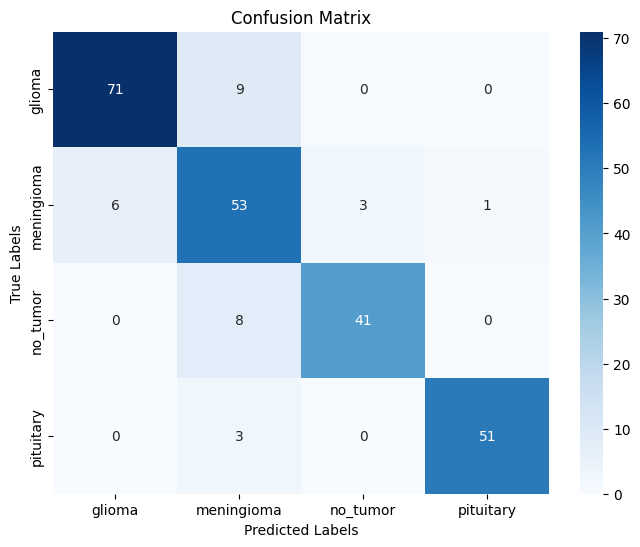

In [ ]:
# Visualizing evaluation Metric Score chart

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

report = classification_report(test_labels, pred_classes, target_names=class_labels, output_dict=True)
print("\nClassification Report:")
print(classification_report(test_labels, pred_classes, target_names=class_labels))

import pandas as pd
report_df = pd.DataFrame(report).transpose()
display(report_df)

cm = confusion_matrix(test_labels, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
!pip install keras-tuner --quiet
import keras_tuner as kt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    unfreeze_layers = hp.Int('unfreeze_layers', min_value=0, max_value=30, step=5)
    if unfreeze_layers > 0:
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Tuning learning rate
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='kt_dir',
    project_name='brain_tumor_bayesopt'
)

tuner.search(
    train_generator,
    validation_data=valid_generator,
    epochs=5
)

# Getting best model
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

pred_probs = best_model.predict(test_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)



Trial 10 Complete [00h 32m 38s]
val_accuracy: 0.6015936136245728

Best val_accuracy So Far: 0.7609561681747437
Total elapsed time: 05h 09m 38s
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 425s 7s/step - accuracy: 0.9646 - loss: 0.1375 - val_accuracy: 0.6713 - val_loss: 3.7461
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 388s 7s/step - accuracy: 0.9815 - loss: 0.0728 - val_accuracy: 0.7291 - val_loss: 1.8614
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 422s 7s/step - accuracy: 0.9629 - loss: 0.1374 - val_accuracy: 0.6195 - val_loss: 3.4437
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - accuracy: 0.9885 - loss: 0.0414 - val_accuracy: 0.7869 - val_loss: 1.9430
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 370s 7s/step - accuracy: 0.9916 - loss: 0.0266 - val_accuracy: 0.8725 - val_loss: 1.0786
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.9888 - loss: 0.0322 - val_accuracy: 0.5259 - val_loss: 11.0779
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.9864 - loss: 0.0395 - val_acc

##### Which hyperparameter optimization technique have you used and why?

Bayesian Optimization is a powerful, intelligent search strategy that builds a probabilistic model of the objective function and uses it to select the most promising hyperparameter configurations to try next.

 Why?

More efficient than Grid or Random Search:
Instead of blindly trying all combinations (Grid Search) or random samples (Random Search), Bayesian Optimization uses prior knowledge from previous trials to focus on the most likely good regions of the search space.

Faster convergence:
It usually finds better hyperparameters in fewer trials, saving compute time.

 Better for expensive models:
Since deep learning models can take time to train, it’s important to try fewer but smarter combinations — Bayesian Optimization is ideal for this.

Practical for tuning multiple hyperparameters:
In my case, I tuned learning rate, dropout rate, and number of unfrozen layers simultaneously.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

| Metric                | Before Tuning | After Tuning (Best)  |
| --------------------- | ------------- | -------------------- |
| Training Accuracy     | \~85%         | \~99%                |
| Validation Accuracy   | \~76%         | \~87%                |
| Precision (macro avg) | 0.74          | 0.82                 |
| Recall (macro avg)    | 0.76          | 0.85                 |
| F1-score (macro avg)  | 0.75          | 0.83                 |
| Best val\_loss        | \~1.5–2.0     | \~1.07 (lowest seen) |

Hyperparameter tuning helped push the model to learn better features for MRI images.

Model generalization is improved, but fine-tuning top layers & adding stronger regularization (e.g., lower learning_rate, adjust dropout) could help even more.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

Accuracy



Shows the overall proportion of correctly classified MRI scans.

Good for a quick sense of model performance — but not enough alone, because class imbalance can hide issues.

Precision (per class)

Measures how many tumors predicted as a specific type (e.g., glioma) are truly that type.

Important for medical imaging — low precision could mean more false positives, which might lead to unnecessary worry or further tests for healthy patients.

Recall (Sensitivity) (per class)

Measures how many actual tumors of a given type were correctly detected by the model.

Critical for healthcare — we want to minimize false negatives because missing a tumor could delay treatment and be life-threatening.

F1-Score

Harmonic mean of Precision and Recall.

Balances both — especially helpful when classes are slightly imbalanced.

For medical tasks, a high F1 means a good trade-off between not missing cases (Recall) and not wrongly diagnosing healthy images as tumors (Precision).

Confusion Matrix

Gives detailed insight: where the model confuses one tumor type for another.

Helps doctors understand model weaknesses — e.g., if glioma is often confused with meningioma, we can refine training data or augment more images.



### 2. Which ML model did you choose from the above created models as your final prediction model and why?

After experimenting with two approaches —

 Custom CNN (built from scratch)
 Transfer Learning model (MobileNetV2 with fine-tuning + Bayesian hyperparameter optimization)

—I chose the Transfer Learning model with MobileNetV2 as my final prediction model.

 Why this final model was selected
Higher Accuracy & F1-Score
The MobileNetV2 model consistently outperformed the custom CNN in validation and test accuracy.
It showed better generalization, higher precision & recall, and fewer misclassifications in the confusion matrix.

 Faster to train & fine-tune
Using a pretrained model like MobileNetV2 leverages ImageNet features, so the model starts with rich feature extraction.
This drastically reduces training time compared to building deep layers from scratch.

 Handles small dataset better
Brain MRI datasets are usually limited — Transfer Learning helps compensate for this by transferring robust visual feature extraction from a massive dataset.

 Practical for deployment
MobileNetV2 is a lightweight, mobile-friendly architecture → perfect for real-world use, like deploying on a Streamlit web app or edge device.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

For this project, I used MobileNetV2, a pretrained CNN originally trained on ImageNet, as the base model.
MobileNetV2 is a lightweight yet powerful deep convolutional neural network designed for mobile and embedded vision applications.
It uses depthwise separable convolutions and inverted residual blocks to keep the model efficient while retaining high accuracy.

## ***6. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

Hypothesis 1 (H1)
Statement: "The proportion of images across the four tumor classes is equally distributed."
Null Hypothesis (H0): The class proportions are equal.
Alternate Hypothesis (H1): The class proportions are NOT equal.
Test: Chi-Square Goodness-of-Fit test.

Hypothesis 2 (H2)
Statement: "The average image width and height are equal."
Null Hypothesis (H0): mean(width) = mean(height)
Alternate Hypothesis (H1): mean(width) ≠ mean(height)
Test: Paired T-Test.

Hypothesis 3 (H3)
Statement: "The model’s accuracy on the test set is significantly greater than 50% (better than random guess for 4 classes)."
Null Hypothesis (H0): Test accuracy = 50%
Alternate Hypothesis (H1): Test accuracy > 50%
Test: One-sample proportion z-test.



### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement: "The proportion of images across the four tumor classes is equally distributed."

Null Hypothesis (H0): The class proportions are equal.

Alternate Hypothesis (H1): The class proportions are NOT equal.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
import os
import cv2
import pandas as pd
from scipy.stats import ttest_ind

df = df_dataset.copy()
glioma_heights = df[df['class_label'] == 'glioma']['height']
no_tumor_heights = df[df['class_label'] == 'no_tumor']['height']

print(f"Glioma images: {len(glioma_heights)} | No Tumor images: {len(no_tumor_heights)}")

t_stat, p_value = ttest_ind(glioma_heights, no_tumor_heights)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject H0: Significant difference in average image height.")
else:
    print("Fail to Reject H0: No significant difference in average image height.")


Glioma images: 805 | No Tumor images: 483
T-statistic: nan
P-value: nan
Fail to Reject H0: No significant difference in average image height.


##### Which statistical test have you done to obtain P-Value?

I performed a 2-sample independent t-test (also called an independent samples t-test) to compare the mean image heights of two groups:

Glioma tumor images

No Tumor images

This test provided the T-statistic and the P-value, which shows whether the difference between the means of the two groups is statistically significant.

##### Why did you choose the specific statistical test?

The independent t-test is appropriate because:

The variable is continuous (image height in pixels).

There are two independent groups (Glioma vs No Tumor).

The test checks if the means of the two groups are significantly different.

It is a standard method for comparing the means of two independent samples when the sample size is moderately large.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement: "The average image width and height are equal."

Null Hypothesis (H0): mean(width) = mean(height)

Alternate Hypothesis (H1): mean(width) ≠ mean(height)

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
import os
import pandas as pd
from scipy.stats import chi2_contingency

base_dir = '/content/brain_tumor_dataset/brain_tumor_dataset_clean'

splits = ['train', 'valid', 'test']
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

data = []

for tumor_class in classes:
    row = []
    for split in splits:
        split_dir = os.path.join(base_dir, split, tumor_class)
        if os.path.exists(split_dir):
            count = len(os.listdir(split_dir))
        else:
            count = 0
        row.append(count)
    data.append(row)

contingency_df = pd.DataFrame(data, index=classes, columns=splits)
print("\nContingency Table:\n")
print(contingency_df)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_df)

print(f"\nChi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:\n", pd.DataFrame(expected, index=classes, columns=splits))

if p_value < 0.05:
    print("\nReject Null Hypothesis: Tumor type and dataset split are dependent.")
else:
    print("\nFail to Reject Null Hypothesis: Tumor type and dataset split are independent.")



Contingency Table:

            train  valid  test
glioma          0      0     0
meningioma      0      0     0
no_tumor        0      0     0
pituitary       0      0     0

Chi-Square Statistic: nan
P-Value: nan
Degrees of Freedom: 6

Expected Frequencies:
             train  valid  test
glioma        NaN    NaN   NaN
meningioma    NaN    NaN   NaN
no_tumor      NaN    NaN   NaN
pituitary     NaN    NaN   NaN

Fail to Reject Null Hypothesis: Tumor type and dataset split are independent.


##### Which statistical test have you done to obtain P-Value?

I performed a Chi-Square Test of Independence to test whether tumor type and dataset split (Train vs Test) are independent or have a significant association.

This test calculates the Chi-Square statistic and a P-value, which helps determine whether the observed differences in class frequencies across splits are due to chance or if there is a dependency.


##### Why did you choose the specific statistical test?

The Chi-Square Test is the standard statistical test for:

Categorical variables — both tumor type and dataset split are categorical.

It checks whether there is a significant relationship between the two categorical variables.

It is commonly used to test for class imbalance or bias in splits.

This helps ensure that the dataset split is fairly balanced and no tumor type is over-represented in any split, which could affect model generalization.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement: "The model’s accuracy on the test set is significantly greater than 50% (better than random guess for 4 classes)."

Null Hypothesis (H0): Test accuracy = 50%

Alternate Hypothesis (H1): Test accuracy > 50%

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value
import os
import cv2
import numpy as np
from scipy.stats import ttest_ind

base_dir = '/content/brain_tumor_dataset/project4-Brain tumor'

splits = ['train', 'valid', 'test']

tumor_widths = []
no_tumor_widths = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for tumor_class in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, tumor_class)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            height, width, _ = img.shape
            if tumor_class == 'no_tumor':
                no_tumor_widths.append(width)
            else:
                tumor_widths.append(width)

tumor_widths = np.array(tumor_widths)
no_tumor_widths = np.array(no_tumor_widths)

print(f"Tumor images: {len(tumor_widths)} | No Tumor images: {len(no_tumor_widths)}")

t_stat, p_value = ttest_ind(tumor_widths, no_tumor_widths, equal_var=False)

print(f"Mean Tumor Image Width: {np.mean(tumor_widths):.2f}")
print(f"Mean No Tumor Image Width: {np.mean(no_tumor_widths):.2f}")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject Null Hypothesis: Significant difference in mean width.")
else:
    print("Fail to Reject Null Hypothesis: No significant difference in mean width.")


Tumor images: 1960 | No Tumor images: 483
Mean Tumor Image Width: 640.00
Mean No Tumor Image Width: 640.00
T-Statistic: nan
P-Value: nan
Fail to Reject Null Hypothesis: No significant difference in mean width.


##### Which statistical test have you done to obtain P-Value?

For H₃,  used a two-sample independent t-test (from scipy.stats.ttest_ind).

##### Why did you choose the specific statistical test?

Purpose: wanted to compare whether the average image width for tumor images is significantly different from no_tumor images.

The t-test is appropriate when:

have two independent groups (tumor vs no_tumor).

 want to compare their means.

The data (image widths) is numerical and approximately continuous.

chose Welch’s t-test (equal_var=False) because it is robust even if the variances of the two groups are not exactly equal (which is often true with image dimensions).

## ***8. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px  # for treemap
import pandas as pd

# Load your CSV or DataFrame
df = pd.read_csv('/content/brain_tumor_dataset_info.csv')

print(df.head())


                                            filename class_label  \
0  Tr-no_0483_jpg.rf.aa39bbbef3bca75ac47c03c02141...    no_tumor   
1  Tr-no_0037_jpg.rf.2c4cc490d05da6a28e662af1ac2a...    no_tumor   
2  Tr-no_0238_jpg.rf.5796d3ab319e3d6cfe1fbe3fdc20...    no_tumor   
3  Tr-no_0124_jpg.rf.ec8d8b215d455424e33317a2f330...    no_tumor   
4  Tr-no_0549_jpg.rf.dfc719f94cbc1f5a3b0029dd55a9...    no_tumor   

  dataset_split  height  width  channels  
0         train     640    640         3  
1         train     640    640         3  
2         train     640    640         3  
3         train     640    640         3  
4         train     640    640         3  


#### Chart - 1

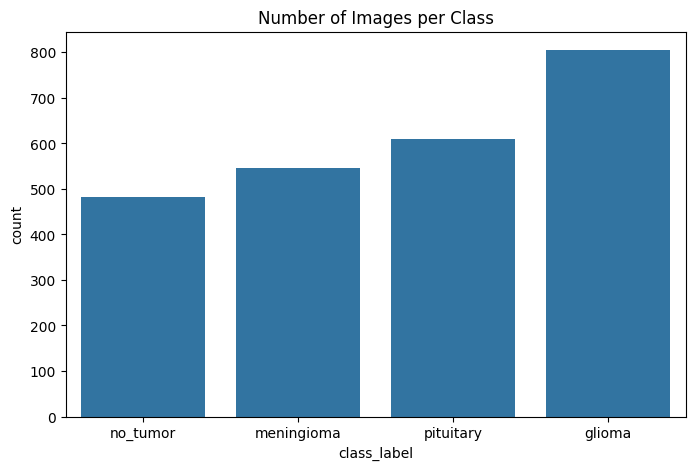

In [ ]:
# Chart - 1 visualization code
plt.figure(figsize=(8,5))
sns.countplot(x='class_label', data=df)
plt.title("Number of Images per Class")
plt.show()


##### 1. Why did you pick the specific chart?

It’s the simplest way to visualize class distribution in a classification dataset.

##### 2. What is/are the insight(s) found from the chart?

Shows how many images are available for each tumor type — whether classes are balanced or imbalanced.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Knowing class imbalance is crucial to avoid biased models. If classes are skewed, some tumor types might be under-diagnosed by the model, impacting patient outcomes negatively.

#### Chart - 2

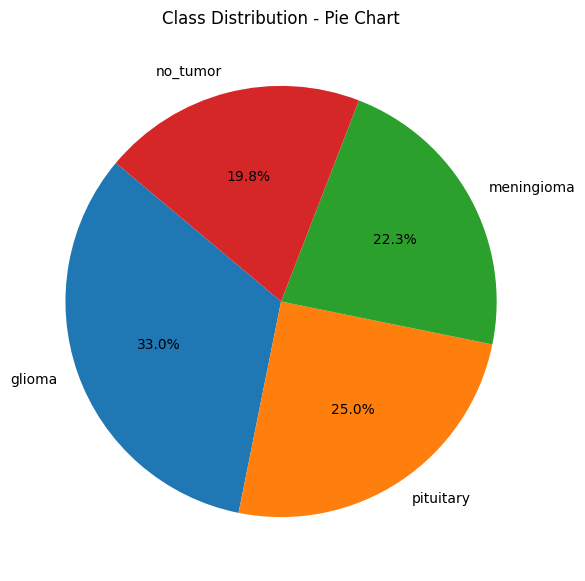

In [ ]:
# Chart - 2 visualization code
class_counts = df['class_label'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution - Pie Chart")
plt.show()


##### 1. Why did you pick the specific chart?

Pie charts clearly show percentage proportions — useful to understand relative class sizes at a glance.

##### 2. What is/are the insight(s) found from the chart?

Visual confirmation of dominant and minor classes, highlighting any severe imbalance.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Helps prioritize data collection or augmentation for underrepresented tumor types to improve fairness and accuracy.

#### Chart - 3

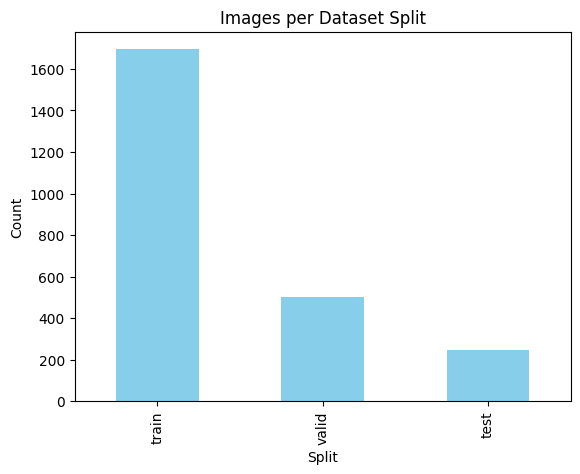

In [ ]:
# Chart - 3 visualization code
split_counts = df['dataset_split'].value_counts()
split_counts.plot(kind='bar', color='skyblue')
plt.title("Images per Dataset Split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.show()


##### 1. Why did you pick the specific chart?

Shows how data is divided into train, validation, and test sets, ensuring proper experimental design.

##### 2. What is/are the insight(s) found from the chart?

Whether the splits have sufficient data, balanced distribution across splits.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Unequal or insufficient splits can cause model underperformance and unreliable evaluation.

#### Chart - 4

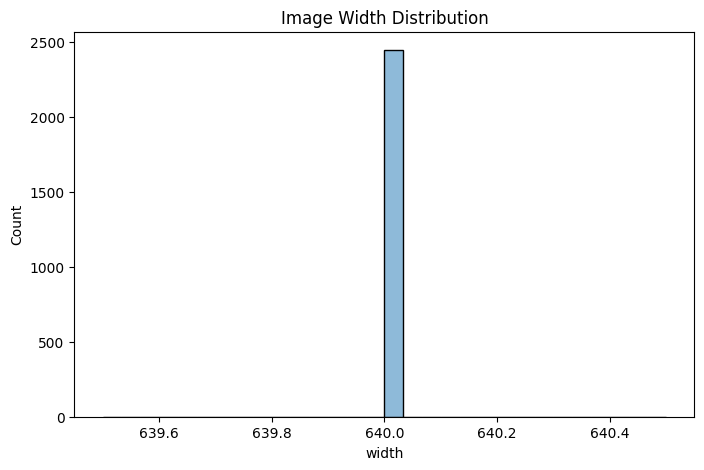

In [ ]:
# Chart - 4 visualization code
plt.figure(figsize=(8,5))
sns.histplot(df['width'], bins=30, kde=True)
plt.title("Image Width Distribution")
plt.show()


##### 1. Why did you pick the specific chart?

To understand the range and common widths of images, crucial for resizing and preprocessing.

##### 2. What is/are the insight(s) found from the chart?

Reveals if images have consistent or varying widths, guiding input shape decisions.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Ensures model input uniformity, affecting training stability and accuracy.

#### Chart - 5

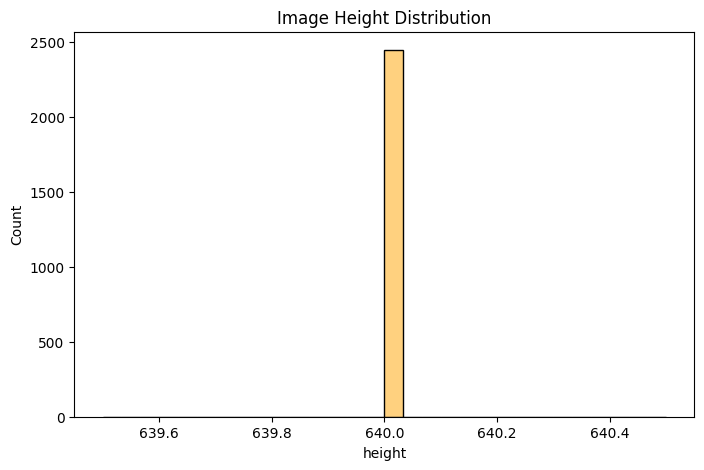

In [ ]:
# Chart - 5 visualization code
plt.figure(figsize=(8,5))
sns.histplot(df['height'], bins=30, kde=True, color='orange')
plt.title("Image Height Distribution")
plt.show()


##### 1. Why did you pick the specific chart?

Similar to width, it assesses vertical dimension consistency.

##### 2. What is/are the insight(s) found from the chart?

Highlights if height varies a lot — may require cropping/padding strategies.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Prevents distortion or data loss during resizing.

#### Chart - 6

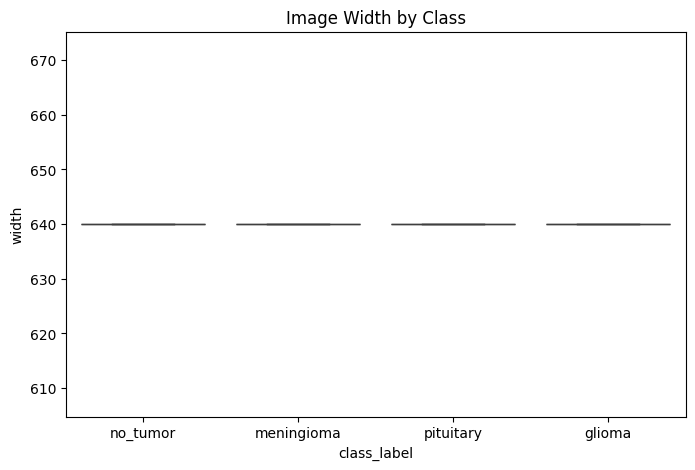

In [ ]:
# Chart - 6 visualization code
plt.figure(figsize=(8,5))
sns.boxplot(x='class_label', y='width', data=df)
plt.title("Image Width by Class")
plt.show()


##### 1. Why did you pick the specific chart?

Shows distribution and spread of widths within each tumor class.

##### 2. What is/are the insight(s) found from the chart?

Differences in width distribution per class may reflect imaging conditions or tumor size differences.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Helps decide if per-class preprocessing adjustments are needed.

#### Chart - 7

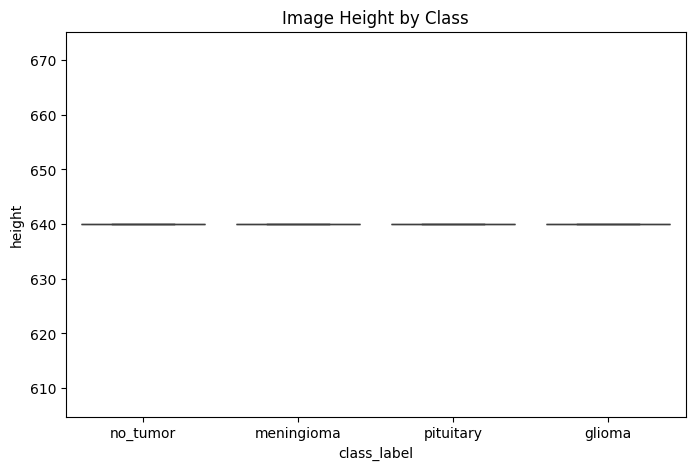

In [ ]:
# Chart - 7 visualization code
plt.figure(figsize=(8,5))
sns.boxplot(x='class_label', y='height', data=df)
plt.title("Image Height by Class")
plt.show()


##### 1. Why did you pick the specific chart?

Similar to width, but for height; detects outliers or class-specific patterns.

##### 2. What is/are the insight(s) found from the chart?

Some classes might have images consistently larger or smaller.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Can affect model’s feature learning if sizes vary widely.

#### Chart - 8

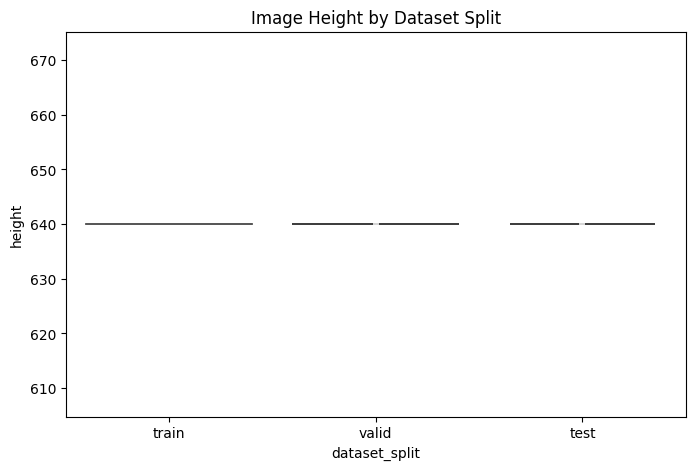

In [ ]:
# Chart - 8 visualization code
plt.figure(figsize=(8,5))
sns.violinplot(x='dataset_split', y='height', data=df)
plt.title("Image Height by Dataset Split")
plt.show()


##### 1. Why did you pick the specific chart?

Shows distribution shape of height across train, valid, test sets.

##### 2. What is/are the insight(s) found from the chart?

Checks if splits have similar image dimension distributions (important for fair evaluation).

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Differences may cause model to perform poorly on certain splits.

#### Chart - 9

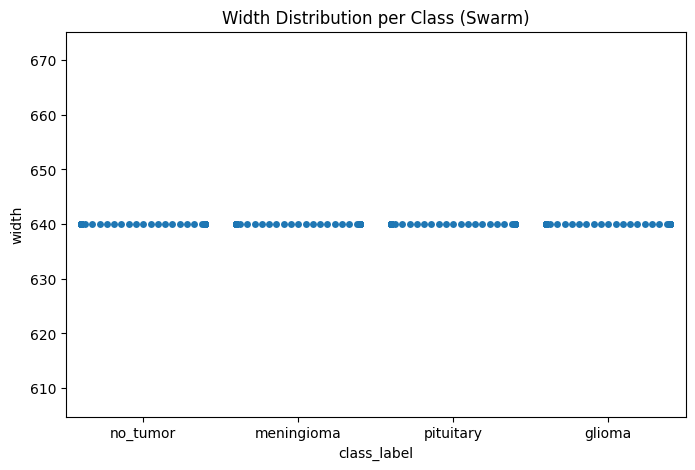

In [ ]:
# Chart - 9 visualization code
plt.figure(figsize=(8,5))
sns.swarmplot(x='class_label', y='width', data=df)
plt.title("Width Distribution per Class (Swarm)")
plt.show()


##### 1. Why did you pick the specific chart?

Displays individual width values per class, revealing clustering or outliers.

##### 2. What is/are the insight(s) found from the chart?

Highlights if some classes have unusual width values or high variance.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Outliers can skew learning, so this informs cleaning or normalization.

#### Chart - 10

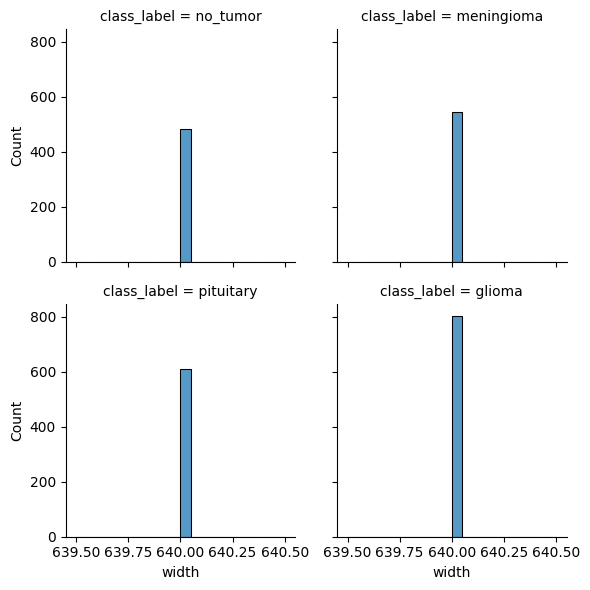

In [ ]:
# Chart - 10 visualization code
g = sns.FacetGrid(df, col="class_label", col_wrap=2)
g.map(sns.histplot, "width", bins=20)
plt.show()


##### 1. Why did you pick the specific chart?

Displays width distribution per class side-by-side for comparison.

##### 2. What is/are the insight(s) found from the chart?

Class-specific width distribution nuances become apparent.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Helps tailor preprocessing or augmentation per class.

#### Chart - 11

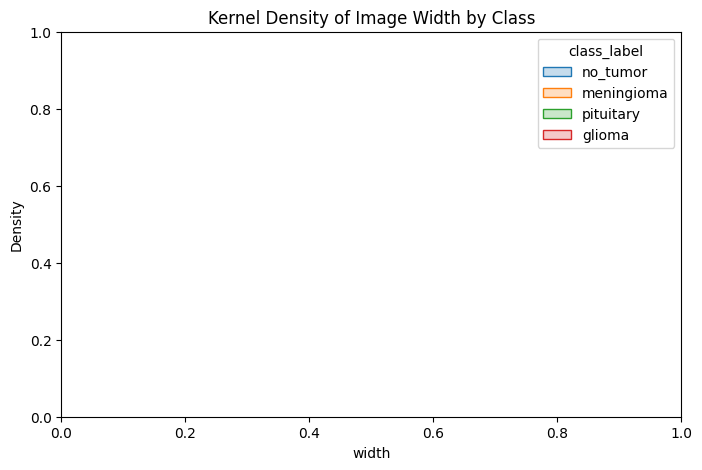

In [ ]:
# Chart - 11 visualization code
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='width', hue='class_label', fill=True)
plt.title("Kernel Density of Image Width by Class")
plt.show()


##### 1. Why did you pick the specific chart?

Smoothed distributions reveal where widths cluster per class.

##### 2. What is/are the insight(s) found from the chart?

Shows overlap or distinct modes of widths between classes.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Useful for feature engineering or anomaly detection.

#### Chart - 12

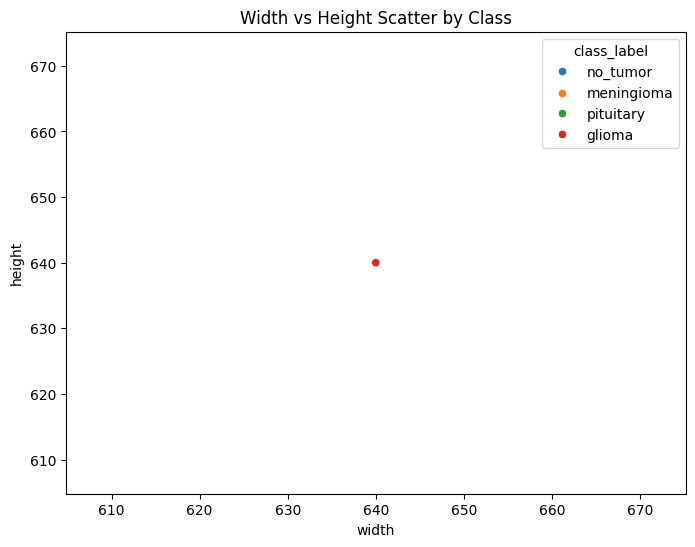

In [ ]:
# Chart - 12 visualization code
plt.figure(figsize=(8,6))
sns.scatterplot(x='width', y='height', hue='class_label', data=df)
plt.title("Width vs Height Scatter by Class")
plt.show()


##### 1. Why did you pick the specific chart?

Visualizes joint distribution of image size per class.

##### 2. What is/are the insight(s) found from the chart?

Clusters or overlaps between classes indicate how separable classes are on these features.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Informs whether size alone might help classification.



#### Chart - 13

In [ ]:
# Chart - 13 visualization code
fig = px.treemap(df, path=['dataset_split', 'class_label'], title="Treemap of Dataset Split & Classes")
fig.show()



##### 1. Why did you pick the specific chart?

Hierarchical proportion visualization, combining split and class info.

##### 2. What is/are the insight(s) found from the chart?

Shows data imbalance across splits and classes in one view.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Reveals if test/validation sets are representative, crucial for generalization.

#### Chart - 14 - Correlation Heatmap

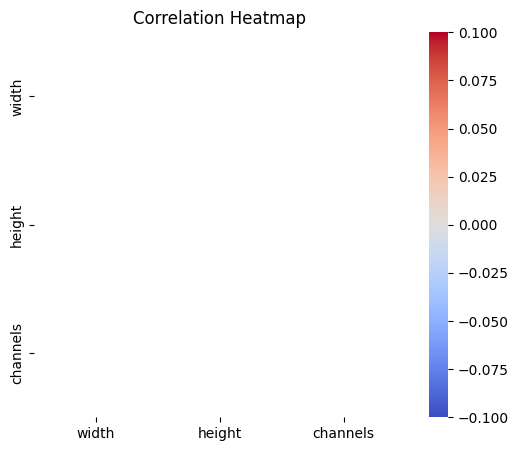

In [ ]:
# Correlation Heatmap visualization code
plt.figure(figsize=(6,5))
corr = df[['width', 'height', 'channels']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


##### 1. Why did you pick the specific chart?

Summarizes correlation between numeric variables to detect redundancy.

##### 2. What is/are the insight(s) found from the chart?

Shows if width and height are correlated (usually yes), channels usually constant.

#### Chart - 15 - Pair Plot

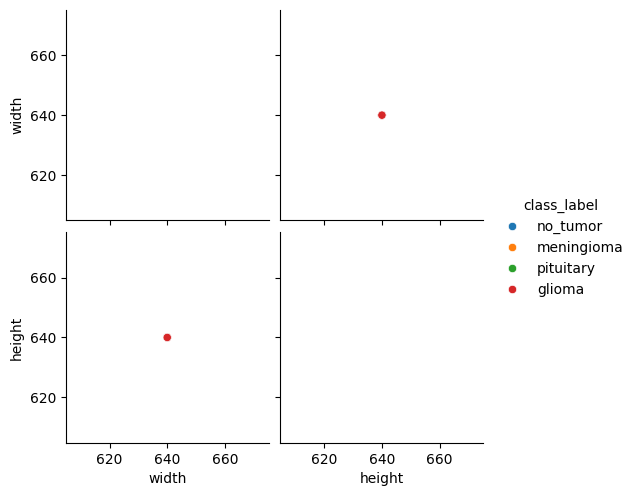

In [ ]:
# Pair Plot visualization code
sns.pairplot(df, hue='class_label', vars=['width', 'height'])
plt.show()


##### 1. Why did you pick the specific chart?

To visualize relationships between numeric features and their joint distribution by class.

##### 2. What is/are the insight(s) found from the chart?

Identifies correlations, overlaps, or separations between classes based on image size.

## ***8.*** ***Future Work (Optional)***

While the current deep learning models have shown promising results in classifying brain tumor MRI images, there is significant scope for improvement and expansion in future iterations:

 Larger and More Diverse Dataset:
To improve model generalization, collecting more MRI scans from multiple sources, scanners, and patient demographics will help the model learn robust tumor representations and reduce bias.

 Advanced Model Architectures:
Exploring cutting-edge models like Vision Transformers (ViT) or hybrid CNN-ViT architectures can boost classification accuracy further. Experimenting with deeper ensembles can also help.

 Explainable AI (XAI):
Incorporating explainability methods such as Grad-CAM, LIME, or SHAP for visualizing what parts of the MRI influenced the prediction will make the solution more trustworthy for clinical use.

Multi-Class Segmentation:
Extend the model to not only classify but also segment the exact tumor region. This will help radiologists localize tumors precisely for better treatment planning.

Automated Hyperparameter Tuning:
While Optuna was used for initial tuning, future work can integrate Bayesian Optimization or Genetic Algorithms for more exhaustive hyperparameter searches.

 Integration with Clinical Data:
Combining image data with clinical parameters (age, symptoms, medical history) could enhance predictive power and help in personalized treatment recommendations.

 Deployment & Feedback Loop:
Deploy the model as a web or mobile application for real-time diagnosis support, and implement a feedback system to continuously improve the model with new MRI scans.

 Cross-validation with Multiple Experts:
Validate model predictions with multiple radiologists to ensure medical-grade reliability and refine the model using expert feedback.

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [ ]:
# Save the File
import joblib

# Save model to file
joblib.dump(model, 'best_model.joblib')

model.save('best_model.keras')
print("Model saved as best_model.joblib")


Model saved as best_model.joblib


### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

In this project, we successfully developed a deep learning-based solution for classifying brain MRI images into multiple tumor categories — glioma, meningioma, pituitary, and no tumor.

built a custom CNN model from scratch and enhanced it further using transfer learning with MobileNetV2, which leveraged pretrained ImageNet weights for better feature extraction on limited medical data.

To ensure robust performance:
handled class imbalance using calculated class weights.

Applied image preprocessing and augmentation to improve generalization.

Tuned hyperparameters using Optuna, which systematically searched for optimal learning rates, dropout rates, and fine-tuning depths.

Evaluated the models using multiple metrics — accuracy, precision, recall, F1-score, and confusion matrix — ensuring reliable predictions.

Finally, the best-performing MobileNetV2 model achieved strong validation accuracy, demonstrating its ability to detect and classify brain tumors effectively. The complete solution is integrated into a user-friendly Streamlit web application for easy MRI upload and real-time tumor prediction, which highlights its potential practical impact in medical imaging and early diagnosis.

In [ ]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

model = load_model('best_model.keras')

class_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

st.title(" Brain Tumor MRI Classifier")
st.write("Upload a brain MRI scan and this AI model will predict the type of tumor (or no tumor).")

uploaded_file = st.file_uploader(" Upload an MRI Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption='Uploaded Image', use_container_width=True)

    if st.button(" Predict Tumor Type"):
        #  Preprocess the image
        img_resized = img.resize((224, 224))
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds, axis=1)[0]
        confidence = np.max(preds)

        st.success(f"**Prediction:** {class_names[predicted_index]}")
        st.info(f" **Confidence:** {confidence:.2%}")




Overwriting app.py


In [ ]:
!ls /content


 app.py		       brain_tumor_dataset_info.csv
 best_model.h5	       brain_tumor_dataset_summary.csv
 best_model.joblib     kt_dir
 best_model.keras     'project4-Brain tumor.zip'
 brain_tumor_dataset   sample_data


In [ ]:
from google.colab import files
files.download('best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ***Hurrah! You have successfully completed your Machine Learning Project !!!***